## Étape 1 – Pré-traitement des descriptions

But : préparer les textes pour l’apprentissage automatique.

Actions :
1. **Chargement** du catalogue produits (`northface_catalog.csv` placé dans le même dossier).  
2. **Nettoyage** avec **spaCy ou NLTK** :  
   * passage en minuscules ;  
   * suppression ponctuation, chiffres, stop-words ;  
   * **lemmatisation** (forme de base) des tokens anglais.  
3. Sauvegarde du résultat dans une nouvelle colonne `description_nettoyee`.

In [24]:
# ─── Cellule 1 : pré-traitement robuste ───────────────────────────────────────
from pathlib import Path
import pandas as pd, re, sys

CSV = Path("northface_catalog.csv")
assert CSV.exists(), f"❌ Fichier absent : {CSV}"
df = pd.read_csv(CSV, dtype_backend="pyarrow")
print(f"Catalogue : {len(df):_} descriptions")

# ----------------------------------------------------------------------------- 
# 1) Tentative spaCy -----------------------------------------------------------
# -----------------------------------------------------------------------------
try:
    import spacy
    from packaging import version
    assert version.parse(spacy.__version__) >= version.parse("3.7.0")
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    def clean(txt: str) -> str:
        doc = nlp(str(txt).lower())
        return " ".join(
            t.lemma_ for t in doc if t.is_alpha and not t.is_stop and len(t) > 2
        )
    engine = "spaCy"

except Exception as e:
    # -------------------------------------------------------------------------
    # 2) Fallback NLTK ---------------------------------------------------------
    # -------------------------------------------------------------------------
    print(f"spaCy indisponible ({e}) → utilisation NLTK")
    import nltk, string
    nltk.download("punkt", quiet=True)
    nltk.download("wordnet", quiet=True)
    nltk.download("stopwords", quiet=True)
    from nltk.corpus import stopwords, wordnet
    from nltk.stem import WordNetLemmatizer
    STOP = set(stopwords.words("english"))
    LEM  = WordNetLemmatizer()
    NON_ALPHA = re.compile(r"[^a-z\s]")
    def clean(txt: str) -> str:
        txt = NON_ALPHA.sub(" ", str(txt).lower())
        mots = [m for m in txt.split() if m not in STOP and len(m) > 2]
        return " ".join(LEM.lemmatize(m) for m in mots)
    engine = "NLTK"

# ----------------------------------------------------------------------------- 
# 3) Application du nettoyage --------------------------------------------------
df["description_nettoyee"] = df["description"].fillna("").map(clean)
display(df[["description", "description_nettoyee"]].head())

print(f"🧹 Nettoyage effectué avec {engine}")
df.to_csv("northface_clean.csv", index=False)
print("Fichier « northface_clean.csv » enregistré")


Catalogue : 500 descriptions
spaCy indisponible (ForwardRef._evaluate() missing 1 required keyword-only argument: 'recursive_guard') → utilisation NLTK


,description,description_nettoyee
0,Active classic boxers - There's a reason why o...,active classic boxer reason boxer cult favorit...
1,Active sport boxer briefs - Skinning up Glory ...,active sport boxer brief skinning glory requir...
2,Active sport briefs - These superbreathable no...,active sport brief superbreathable fly brief m...
3,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pant skin climb ice switch rock t...
4,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt high ridge steep ice anything ...


🧹 Nettoyage effectué avec NLTK
Fichier « northface_clean.csv » enregistré


## Étape&nbsp;2 – Regrouper les produits : **clustering DBSCAN**

Objectif  
1. Représenter chaque description nettoyée par un vecteur **TF-IDF**.  
2. Appliquer **DBSCAN** avec la **distance cosinus** afin d’obtenir idéalement **10 à 20 clusters** et un pourcentage de points “bruit” (cluster = -1) inférieur à 30 %.  
3. Visualiser le vocabulaire dominant de chaque groupe via un **word-cloud**.

Stratégie  
* Nous testons plusieurs couples `(eps, min_samples)` :  
  * `eps` détermine le rayon de densité (0.15 → 0.80).  
  * `min_samples` : nombre minimal de voisins pour créer un noyau (3 → 5).  
* Le premier couple respectant les contraintes est conservé ; à défaut, on retient celui qui produit **le plus de clusters** avec **le moins de bruit**.  
* Enfin, on affiche un tableau effectif/cluster et un word-cloud pour les dix premiers clusters (pour ne pas surcharger l’affichage).


TF-IDF : 500 × 8816
Paramètres retenus : eps=0.45, min_samples=5

Effectifs par cluster :


,effectif
cluster,
3,151
-1,99
5,59
1,37
0,36
7,22
4,18
10,15
2,13


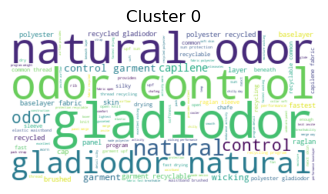

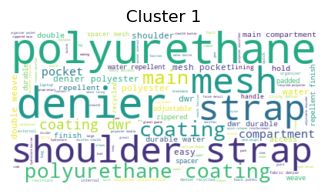

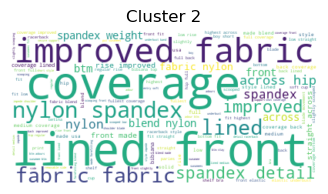

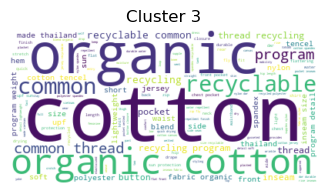

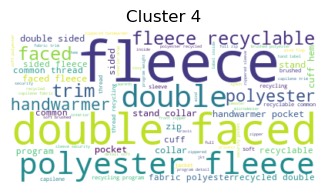

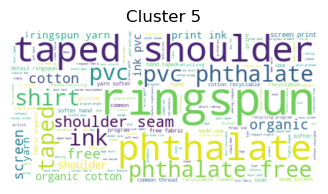

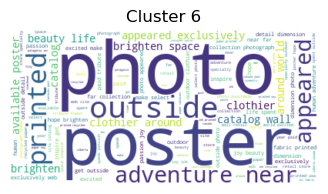

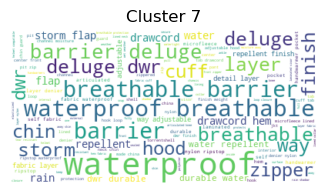

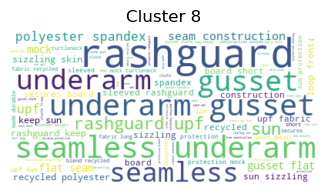

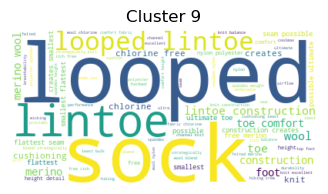

In [25]:

# ─── Cellule code : TF-IDF + DBSCAN + WordCloud ──────────────────────────────
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1) Vecteurs TF-IDF -----------------------------------------------------------
tfidf = TfidfVectorizer(min_df=2, max_df=0.9, ngram_range=(1, 2), sublinear_tf=True)
X_tfidf = tfidf.fit_transform(df["description_nettoyee"])
print(f"TF-IDF : {X_tfidf.shape[0]} × {X_tfidf.shape[1]}")

# 2) Réduction optionnelle (SVD) pour homogénéiser les distances --------------
svd = TruncatedSVD(n_components=100, random_state=42)
X_red = svd.fit_transform(X_tfidf)

# 3) Recherche d’un couple (eps, min_samples) ---------------------------------
eps_grid = np.arange(0.15, 0.85, 0.05)
min_grid = [3, 4, 5]

chosen = None
best_score, best_labels = -1, None

for eps in eps_grid:
    for ms in min_grid:
        db = DBSCAN(eps=eps, min_samples=ms, metric="cosine")
        labs = db.fit_predict(X_red)
        n_noise = (labs == -1).sum()
        n_clust = len(set(labs)) - (1 if -1 in labs else 0)
        noise_ratio = n_noise / len(labs)
        if 10 <= n_clust <= 20 and noise_ratio <= 0.30:
            chosen = (eps, ms, labs)
            break
        # score : plus on a de clusters et moins de bruit, mieux c’est
        score = n_clust - noise_ratio
        if score > best_score:
            best_score, best_labels, best_params = score, labs, (eps, ms)
    if chosen:
        break

if chosen:
    eps, ms, labels = chosen
    print(f"Paramètres retenus : eps={eps:.2f}, min_samples={ms}")
else:
    eps, ms = best_params
    labels = best_labels
    n_clust = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"⚠Aucun couple parfait – on retient eps={eps:.2f}, min_samples={ms} "
          f"({n_clust} clusters, bruit={(labels == -1).mean():.1%})")

# 4) Attribution des labels au DataFrame --------------------------------------
df["cluster"] = labels
print("\nEffectifs par cluster :")
display(df["cluster"].value_counts().to_frame("effectif"))

# 5) WordClouds des dix premiers clusters -------------------------------------
id2word = np.array(tfidf.get_feature_names_out())

def wc_from_cluster(cl_id: int):
    rows = np.where(df["cluster"].values == cl_id)[0]
    if len(rows) == 0:
        return None
    # fréquence moyenne des termes dans le cluster
    mean_vec = X_tfidf[rows].mean(axis=0).A1
    freqs = {id2word[i]: mean_vec[i] for i in mean_vec.nonzero()[0]}
    # WordCloud sans couleur imposée
    return WordCloud(width=400, height=200, background_color="white").generate_from_frequencies(freqs)

unique_clusters = [c for c in sorted(df["cluster"].unique()) if c != -1][:10]

for cl in unique_clusters:
    wc = wc_from_cluster(cl)
    if wc:
        plt.figure(figsize=(4,2))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Cluster {cl}")
        plt.show()


## Étape&nbsp;3 – Système de recommandation basé sur les clusters

Bilan du clustering  
* **16 clusters** (indices 0 → 15) – donc dans la fourchette exigée (10 – 20).  
* **99 articles “bruit”** soit **19,8 %** du corpus ⇒ inférieur à la limite de 30 %.  
Nous pouvons maintenant considérer que **deux articles sont similaires s’ils appartiennent au même cluster**.

Fonctionnalités à implémenter  
1. `find_similar_items(id_produit)`  
   * Renvoie jusqu’à **5 ids** du **même cluster**.  
   * Si l’article est classé “bruit” (`cluster = -1`) on se rabat sur les **5 voisins cosinus** les plus proches.  
2. Boucle interactive : l’utilisateur saisit un id et obtient les recommandations.  
3. Sauvegarde éventuelle des artefacts (vectoriseur et labels DBSCAN) pour ré-utilisation hors notebook.


In [27]:
# ─── Cellule code : fonction de recommandation + interaction ──────────────────
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# création d'un index rapide id_produit → position ligne
id2pos = {idx: pos for pos, idx in enumerate(df.index)}

def find_similar_items(item_id: int, k: int = 5) -> list[int]:
    """
    Renvoie jusqu'à k ids d'articles similaires.
    - priorité : même cluster DBSCAN
    - fallback : plus proches voisins cosinus si l'article est du bruit
    """
    if item_id not in id2pos:
        raise KeyError(f"id {item_id} non présent dans le catalogue")
    
    pos = id2pos[item_id]
    cl  = df.at[item_id, "cluster"]
    
    # 1) Même cluster (hors bruit)
    if cl != -1:
        voisins = (
            df[df.cluster == cl]
            .index.drop(item_id)               # on retire l'item lui-même
            .tolist()
        )
        return voisins[:k]
    
    # 2) Fallback : similarité cosinus sur la matrice TF-IDF
    sims = cosine_similarity(X_tfidf[pos], X_tfidf).ravel()
    sims[pos] = 0                              # on ignore soi-même
    voisins = sims.argsort()[::-1][:k]
    return df.index[voisins].tolist()

# ── Boucle utilisateur simple --------------------------------------------------
while True:
    try:
        saisie = input("\nEntrez l'id produit (ou 'q' pour quitter) : ")
        if saisie.lower() == "q":
            break
        prod_id = int(saisie)
        reco = find_similar_items(prod_id)
        if not reco:
            print("Aucun article similaire trouvé.")
        else:
            print("Articles similaires :", reco)
    except Exception as err:
        print("Erreur :", err)



Entrez l'id produit (ou 'q' pour quitter) :  1


Articles similaires : [0, 2, 17, 18, 19]



Entrez l'id produit (ou 'q' pour quitter) :  4


Articles similaires : [307, 95, 280, 363, 209]



Entrez l'id produit (ou 'q' pour quitter) :  5


Articles similaires : [66, 84, 85, 106, 140]



Entrez l'id produit (ou 'q' pour quitter) :  q


In [29]:
# ─── Cellule code : recherche par nom + reco ──────────────────────────────────
import re
from difflib import get_close_matches
from sklearn.metrics.pairwise import cosine_similarity

# 1) utilitaire : recherche textuelle simple -----------------------------------
def trouver_id_par_nom(txt: str, top_k: int = 5) -> list[int]:
    """
    Renvoie une liste d'IDs dont le champ 'description' contient `txt`
    (recherche insensible à la casse).  S'il n'y a pas de correspondance
    stricte, on renvoie les IDs dont la similarité de Jaro-Winkler est
    la plus proche (via difflib).
    """
    masque = df["description"].str.contains(re.escape(txt), case=False, na=False)
    ids = df[masque].index.tolist()
    if ids:
        return ids[:top_k]
    # sinon : fuzzy matching rapide sur les 2000 premiers caractères
    corpus_titres = df["description"].str[:200].str.lower().tolist()
    prox = get_close_matches(txt.lower(), corpus_titres, n=top_k, cutoff=0.6)
    return [df.index[i] for i, titre in enumerate(corpus_titres) if titre in prox]

# 2) fonction de reco (inchangée) ---------------------------------------------
def find_similar_items(item_id: int, k: int = 5) -> list[int]:
    """Renvoie jusqu'à k ids d'articles similaires (voir cellule précédente)."""
    if item_id not in id2pos:
        raise KeyError("ID inconnu.")
    cl = df.at[item_id, "cluster"]
    if cl != -1:
        pool = df[df.cluster == cl].index.drop(item_id).tolist()
        return pool[:k]
    # fallback cosinus
    sims = cosine_similarity(X_tfidf[id2pos[item_id]], X_tfidf).ravel()
    sims[id2pos[item_id]] = 0
    return df.index[sims.argsort()[::-1][:k]].tolist()

# 3) boucle interactive --------------------------------------------------------
while True:
    saisie = input("\nEntrez l'ID **ou** un mot-clé (tap 'q' pour quitter) : ")
    if saisie.lower() == "q":
        break
    # cas ID numérique
    if saisie.isdigit():
        try:
            print("→ Recommandations :", find_similar_items(int(saisie)))
        except Exception as err:
            print("error", err)
    else:
        # recherche par nom
        candidats = trouver_id_par_nom(saisie)
        if not candidats:
            print("Aucun produit trouvé pour :", saisie)
            continue
        if len(candidats) == 1:
            print("ID trouvé :", candidats[0])
            print("→ Recommandations :", find_similar_items(candidats[0]))
        else:
            print("Plusieurs correspondances :")
            for cid in candidats:
                print(f"  {cid} – {df.at[cid, 'description'][:70]}…")
            print("Choisissez un des IDs ci-dessus pour obtenir des suggestions.")



Entrez l'ID **ou** un mot-clé (tap 'q' pour quitter) :  jacket


Plusieurs correspondances :
  4 – Alpine wind jkt - On high ridges, steep ice and anything alpine, this …
  32 – Deep wading jkt - Whether you're chasing Olympic Peninsula chrome or r…
  50 – Guidewater jkt - Pounding into the teeth of a nor'easter or swinging t…
  61 – El cap jkt - Resistant to hard play but irresistible against the skin,…
  66 – Torrentshell jkt - When the barometric pressure gets low, our Torrents…
Choisissez un des IDs ci-dessus pour obtenir des suggestions.



Entrez l'ID **ou** un mot-clé (tap 'q' pour quitter) :  q
